In [1]:
import sys
sys.path.append('../src')

In [6]:
from data.ingestion import load_car_sales_data
from data.preparation import generate_datasets
from evaluation.key_performance_indicators import kpi_ml
from evaluation.key_performance_indicators import model_mae
import pandas as pd

In [3]:
# Load car sales data
car_sales_df = load_car_sales_data("../data/norway_new_car_sales_by_make.csv")

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [5]:
# Generate forest and extra_trees models
forest_features = {
    "n_jobs": -1,
    "n_estimators": 200,
    "min_samples_split": 15,
    "min_samples_leaf": 4,
    "max_samples": 0.95,
    "max_features": 0.3,
    "max_depth": 8,
    "bootstrap": True,
}
forest = RandomForestRegressor(**forest_features)
extra_trees_features = {
    "n_jobs": -1,
    "n_estimators": 200,
    "min_samples_split": 14,
    "min_samples_leaf": 2,
    "max_samples": 0.9,
    "max_features": 1.0,
    "max_depth": 12,
    "bootstrap": True,
}
extra_trees = ExtraTreesRegressor(**extra_trees_features)

<Axes: xlabel='Number of Months'>

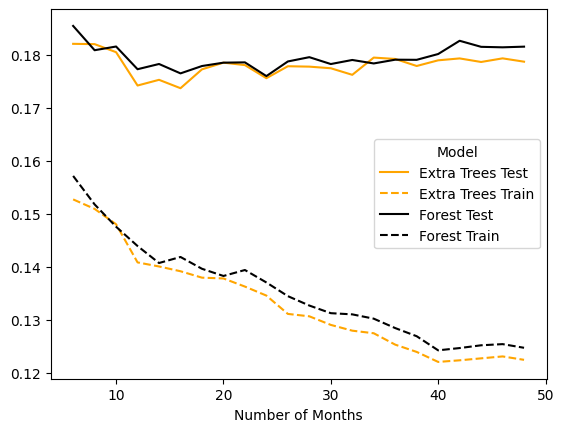

In [7]:
models = [("Forest", forest), ("Extra Trees", extra_trees)]
n_months = range(6, 50, 2)
results = []
for x_length in n_months:
    X_train, y_train, X_test, y_test = generate_datasets(
        df=car_sales_df,
        x_length=x_length,
    )
    for name, model in models:
        model.fit(X=X_train, y=y_train)
        mae_train = model_mae(model=model, X=X_train, y=y_train)
        mae_test = model_mae(model=model, X=X_test, y=y_test)
        results.append([name + " Train", mae_train, x_length])
        results.append([name + " Test", mae_test, x_length])

data = pd.DataFrame(
    results,
    columns=["Model", "MAE %", "Number of Months"]
)
data = data.set_index(["Number of Months", "Model"]).stack().unstack("Model")
data.index = data.index.droplevel(level=1)
data.index.name = "Number of Months"

data.plot(color=["orange"] * 2 + ["black"] * 2, style=["-", "--"] * 2)

In [8]:
from sklearn.model_selection import TimeSeriesSplit

<Axes: xlabel='Number of Months'>

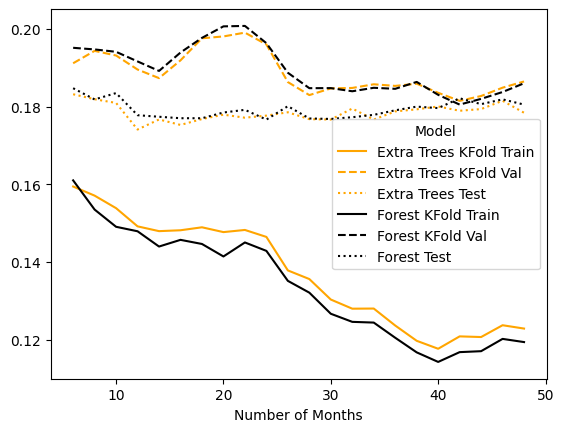

In [9]:
# K-Fold Cross-Validation
results = []
for x_length in n_months:
    X_train, y_train, X_test, y_test = generate_datasets(
        df=car_sales_df,
        x_length=x_length,
    )
    for name, model in models:
        mae_kfold_train = []
        mae_kfold_val = []
        for train_index, val_index in TimeSeriesSplit(n_splits=8).split(X_train):
            X_train_kfold, X_val_kfold = X_train[train_index], X_train[val_index]
            y_train_kfold, y_val_kfold = y_train[train_index], y_train[val_index]

            model.fit(X=X_train_kfold, y=y_train_kfold)
            mae_train = model_mae(model=model, X=X_train_kfold, y=y_train_kfold)
            mae_kfold_train.append(mae_train)
            mae_test = model_mae(model=model, X=X_val_kfold, y=y_val_kfold)
            mae_kfold_val.append(mae_test)

        results.append([name + " KFold Train", sum(mae_kfold_train) / len(mae_kfold_train), x_length])
        results.append([name + " KFold Val", sum(mae_kfold_val) / len(mae_kfold_val), x_length])

        model.fit(X=X_train, y=y_train)
        mae_test = model_mae(model=model, X=X_test, y=y_test)
        results.append([name + " Test", mae_test, x_length])

data = pd.DataFrame(
    results,
    columns=["Model", "MAE %", "Number of Months"]
)
data = data.set_index(["Number of Months", "Model"]).stack().unstack("Model")
data.index = data.index.droplevel(level=1)
data.index.name = "Number of Months"

data.plot(color=["orange"] * 3 + ["black"] * 3, style=["-", "--", ":"] * 2)

In [10]:
from data.preparation import generate_datasets_with_holdout

<Axes: xlabel='Number of Months'>

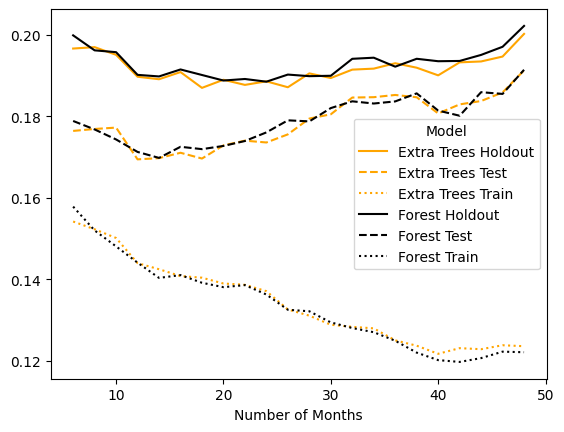

In [12]:
# Holdout Cross-Validation
results = []
for x_length in n_months:
    X_train, y_train, X_holdout, y_holdout, X_test, y_test = generate_datasets_with_holdout(
        df=car_sales_df,
        x_length=x_length,
        holdout_loops=12,
    )
    for name, model in models:
        model.fit(X=X_train, y=y_train)
        mae_train = model_mae(model=model, X=X_train, y=y_train)
        mae_holdout = model_mae(model=model, X=X_holdout, y=y_holdout)
        mae_test = model_mae(model=model, X=X_test, y=y_test)
        results.append([name + " Holdout", mae_holdout, x_length])
        results.append([name + " Train", mae_train, x_length])
        results.append([name + " Test", mae_test, x_length])

data = pd.DataFrame(
    results,
    columns=["Model", "MAE %", "Number of Months"]
)
data = data.set_index(["Number of Months", "Model"]).stack().unstack("Model")
data.index = data.index.droplevel(level=1)
data.index.name = "Number of Months"

data.plot(color=["orange"] * 3 + ["black"] * 3, style=["-", "--", ":"] * 2)